In [1]:
%matplotlib inline  
from fastai.vision import *
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from efficientnet_pytorch import EfficientNet
from ranger import *
from mxresnet import *

Mish activation loaded...


In [2]:
def strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)


def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float, SUFFIX = 'PHASE_1_COS'):
    n = len(learn.data.train_dl)
    anneal_start = int(n*n_epochs*start_pct)
    anneal_end = int(n*n_epochs) - anneal_start
    phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
             TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.callbacks.append(SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}'))
    learn.fit(n_epochs)

In [3]:
PATH = Path('..')
FOLD =0
BS =            64
SZ =            512
IMG_TRAIN_224 = PATH/f'stage_1_train_images_png'
IMG_TEST_224  = PATH/f'stage_1_test_images_png'
DF_TRAIN =      pd.read_csv(PATH/'train_labels_as_strings.csv')
DF_SUBMI =      pd.read_csv(PATH/'stage_1_sample_submission.csv')
EXP_NAME =      f'NB_EXP_10_CV_{FOLD}_TFL_{SZ}_PSD'


DF_SUBMI['fn'] = DF_SUBMI.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.png')
DF_TRAIN['labels'].fillna('', inplace=True)
VAL_IDX = strt_split(DF_TRAIN['fn'], DF_TRAIN['labels'])[FOLD]

In [4]:
DF_TRAIN =      pd.read_csv(PATH/'train_labels_as_strings.csv')
DF_TRAIN['fn'] = DF_TRAIN['fn'].apply(lambda x: f'{IMG_TRAIN_224.name}/{x}')
DF_TRAIN

,fn,labels
0,stage_1_train_images_png/ID_63eb1e259.png,NaN
1,stage_1_train_images_png/ID_2669954a7.png,NaN
2,stage_1_train_images_png/ID_52c9913b1.png,NaN
3,stage_1_train_images_png/ID_4e6ff6126.png,NaN
4,stage_1_train_images_png/ID_7858edd88.png,NaN
...,...,...
674252,stage_1_train_images_png/ID_f737f4cc1.png,NaN
674253,stage_1_train_images_png/ID_4c92d70b5.png,NaN
674254,stage_1_train_images_png/ID_a9797cb3a.png,NaN
674255,stage_1_train_images_png/ID_9375f67bd.png,NaN


In [5]:
DF_PSD = pd.read_csv('../EXP_888/SLH_500_STRINGS.csv')
DF_PSD['fn'] = DF_PSD['fn'].apply(lambda x: f'{IMG_TEST_224.name}/{x}')
DF_PSD

,fn,labels
0,stage_1_test_images_png/ID_28fbab7eb.png,NaN
1,stage_1_test_images_png/ID_877923b8b.png,NaN
2,stage_1_test_images_png/ID_a591477cb.png,NaN
3,stage_1_test_images_png/ID_42217c898.png,NaN
4,stage_1_test_images_png/ID_a130c4d2f.png,NaN
...,...,...
78540,stage_1_test_images_png/ID_028eb9a94.png,NaN
78541,stage_1_test_images_png/ID_12a080682.png,NaN
78542,stage_1_test_images_png/ID_5bc44227a.png,any subarachnoid
78543,stage_1_test_images_png/ID_c76074a3c.png,any subarachnoid


In [6]:
shap_trn = DF_TRAIN.shape[0]
shap_psd = DF_PSD.shape[0]
df_master = pd.concat([DF_TRAIN, DF_PSD], ignore_index=True)

In [7]:
df_master.to_csv('train_labels_as_strings_psd.csv', index=False)

In [8]:
VAL_IDX[1].shape

(539391,)

In [9]:
np.arange(shap_trn-shap_psd, df_master.shape[0])

array([595712, 595713, 595714, 595715, ..., 752798, 752799, 752800, 752801])

In [10]:
VAL_IDX_ = np.concatenate([VAL_IDX[1], np.arange(shap_trn-shap_psd, df_master.shape[0])])
VAL_IDX = (VAL_IDX[0], VAL_IDX_)

In [11]:
VAL_IDX[0].shape, VAL_IDX[1].shape

((134866,), (696481,))

In [12]:
ItemList.label_from_df = modified_label_from_df
test_fns = DF_SUBMI.fn.unique()

data = (ImageList.from_csv('', 'train_labels_as_strings_psd.csv', folder='..')
        .split_by_idxs(valid_idx=VAL_IDX[0], train_idx=VAL_IDX[1])
        .label_from_df(label_delim=' ')
        .transform(tfms = get_transforms(),size=SZ)
        .add_test('../' +IMG_TEST_224.name + '/' + test_fns)
        .databunch(bs=BS))

        

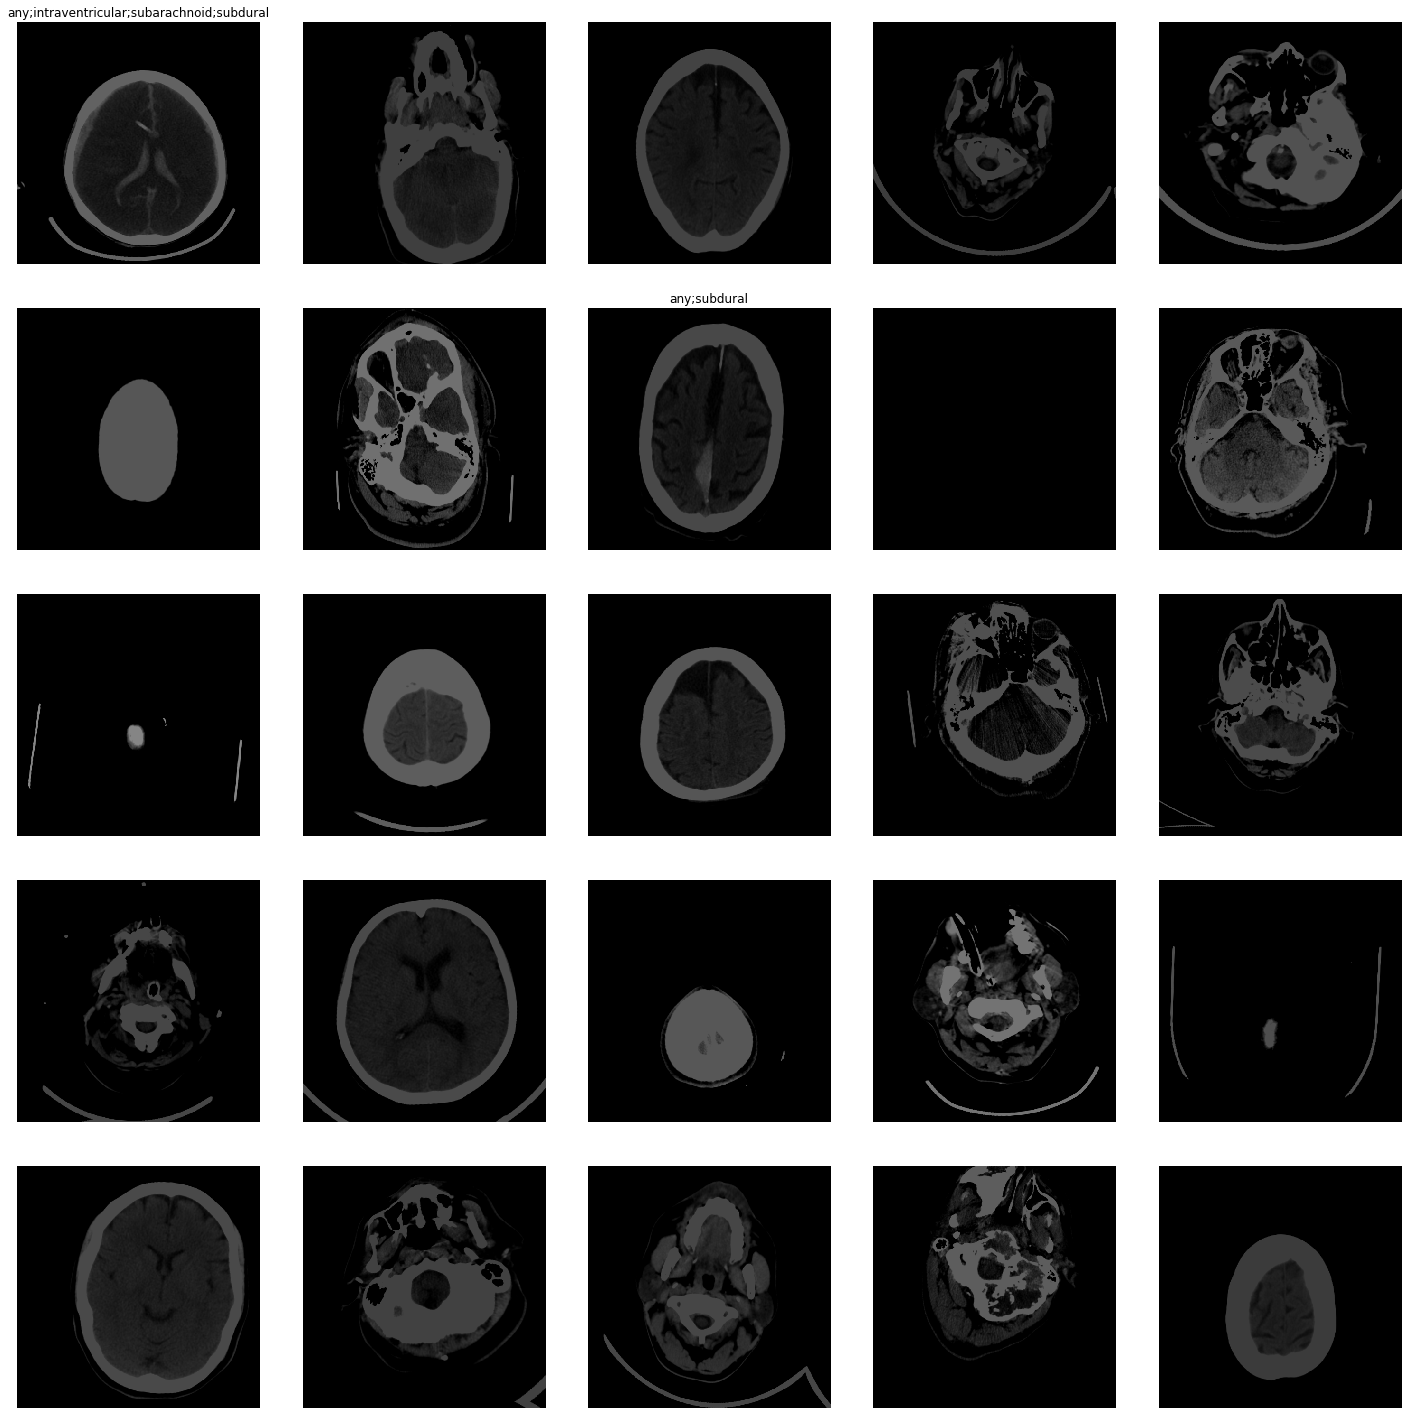

In [13]:
data.show_batch()

In [14]:
md_xrsa =  mxresnet50(c_out=data.c, sa=True)
opt_func = partial(Ranger, betas=(0.95,0.99), eps=1e-6)

In [15]:
learn = Learner(data,
                md_xrsa,
                wd=1e-2,
                bn_wd=False, 
                true_wd=True, 
                opt_func=opt_func,
                metrics=[accuracy_thresh])
learn.path = Path('..')
learn.model = nn.DataParallel(learn.model)
learn.load('NB_EXP_10_CV_0_TFL_512_PHASE_1_COS')
learn.to_fp16()
learn.unfreeze()

set state called


In [17]:
lr = 0.0004
flattenAnneal(learn, lr, 5, 0.7)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.047761,0.056777,0.979495,2:22:16
1,0.046498,0.056559,0.979585,2:22:17
2,0.048634,0.055202,0.980316,2:21:17
3,0.042865,0.055350,0.980489,2:20:32
4,0.040703,0.052786,0.981100,2:21:22


Better model found at epoch 0 with valid_loss value: 0.05677718669176102.
Better model found at epoch 1 with valid_loss value: 0.05655902996659279.
Better model found at epoch 2 with valid_loss value: 0.05520222708582878.
Better model found at epoch 4 with valid_loss value: 0.05278589203953743.
set state called


In [18]:
def get_preds(learn:Learner, sub_fn: str=f'{EXP_NAME}_COS', TTA: bool = False, dt_type = DatasetType.Test):
    if TTA:
        learn.to_fp32()
        preds, targs = learn.TTA(ds_type=dt_type)
        sub_fn = f'{sub_fn}_TTA'
    else:
        preds, targs = learn.get_preds(dt_type)
    ids = []
    labels = []

    for fn, pred in zip(test_fns, preds):
        for i, label in enumerate(data.train_ds.classes):
            ids.append(f"{fn.split('.')[0]}_{label}")
            predicted_probability = '{0:1.10f}'.format(pred[i].item())
            labels.append(predicted_probability)
    pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(f'{sub_fn}.csv', index=False)

In [19]:
get_preds(learn)

In [ ]:
get_preds(learn, TTA=True)

In [ ]:
!sudo shutdown